In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import my_funcs as my

Initial test runs

In [77]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51] #number of particles to use
D = 50 #dimension of the target
num_iter = 30000 #number of iterations
num_runs = 10 #number of runs 
eta = 10e-3 #learning rate
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0
optimizer = my.SGD(eta = 1e-3,gamma = 0.9)
#optimizer = my.AdaGrad(eta = 10e-3, alpha = 0.9)

In [78]:
N = Ns[-1]
C = Cs[-1]

In [ ]:
target_mean = standard_normal.sample()
target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
x0 = standard_normal.sample([N])

t0 = time.time()
x_gpf = my.gpf(x0,p,num_iter = num_iter,eta1 = eta, eta2 = eta, history = True)
t1 = time.time()
x_lin = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer, history = True)
t2 = time.time()

In [ ]:
print('runtime gpf:{:.2f}s'.format(t1 - t0))
print('runtime svgd:{:.2f}s'.format(t2 - t1))

In [ ]:
#calculate the covariance of the particles at each step
cov_gpf = torch.stack([my.estimate_cov(x) for x in x_gpf])
cov_svgd = torch.stack([my.estimate_cov(x) for x in x_lin])

In [ ]:
#calculate the l2 norm of the update step at each step
gpf_l2step = torch.linalg.norm(x_gpf[1:]-x_gpf[:-1],dim=(1,2))
svgd_l2step = torch.linalg.norm(x_lin[1:]-x_lin[:-1],dim=(1,2))

In [ ]:
#calculate the rmse between the mean and the target mean
gpf_mean_rmse = torch.sqrt(torch.mean((torch.mean(x_gpf,1)-p.mean)**2,1))
svgd_mean_rmse = torch.sqrt(torch.mean((torch.mean(x_lin,1)-p.mean)**2,1))
#calculate the rmse between the covariance and the target covariance
gpf_cov_rmse =[torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov_gpf]
svgd_cov_rmse = [torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov_svgd]
#calculate the trace error between the covariance and the target covariance
gpf_cov_tr = [torch.abs(torch.trace(c - p.covariance_matrix)) for c in cov_gpf]
svgd_cov_tr = [torch.abs(torch.trace(c - p.covariance_matrix)) for c in cov_svgd]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].semilogy(gpf_mean_rmse,label='gpf')
axs[0].semilogy(svgd_mean_rmse,label='svgd')
axs[0].set_title('Mean estimate over iterations')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('Log10 RMSE ')
axs[0].legend()
axs[1].semilogy(gpf_cov_rmse,label='gpf')
axs[1].semilogy(svgd_cov_rmse,label='svgd')
axs[1].set_title('Covariance estimate over iterations')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('Log10 RMSE ')
axs[1].legend()
plt.show()

In [ ]:
plt.semilogy(gpf_cov_tr,label='gpf')
plt.semilogy(svgd_cov_tr,label='svgd')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('log10 trace error')
plt.show()

In [ ]:
plt.semilogy(gpf_l2step,label='gpf')
plt.semilogy(svgd_l2step,label='svgd')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Log10 L2 norm of update step')
plt.show()

Grid single runs

In [177]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51] #number of particles to use
D = 50 #dimension of the target
num_iter = 30000 #number of iterations
num_runs = 10 #number of runs 
eta = 10e-3 #learning rate
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0
optimizer = my.AdaGrad(eta = eta, alpha = 0.9) #RMSprop with 0.9 discount

In [178]:
data_path = os.path.join(os.getcwd(), 'data_iter_{}_eta_{}_D_{}'.format(num_iter,eta,D))
if not os.path.exists(data_path):
    os.mkdir(data_path)

In [179]:
runtime = torch.zeros((2,num_runs,len(Cs),len(Ns)))

for run in np.arange(num_runs):
    for i,C in enumerate(Cs):
        for j,N in enumerate(Ns):
            run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))
            
            if not os.path.exists(run_path):
                os.mkdir(run_path)
            else:
                continue
                
            target_mean = standard_normal.sample()
            target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
            p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
            x0 = standard_normal.sample([N])

            t0 = time.time()
            x_gpf = my.gpf(x0,p,num_iter = num_iter,eta1 = eta, eta2 = eta, history = False)
            t1 = time.time()
            x_svgd = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer, history = False)
            t2 = time.time()
            
            torch.save(p,os.path.join(run_path,'target'))
            torch.save(x0,os.path.join(run_path,'x0'))
            torch.save(x_gpf,os.path.join(run_path,'x_gpf'))
            torch.save(x_svgd,os.path.join(run_path,'x_svgd'))
            
            runtime[0,run,i,j] = t1 - t0
            runtime[1,run,i,j] = t2 - t1

In [180]:
print('average runtime: gpf {:.2f}s svgd {:.2f}s'.format(*torch.mean(runtime,(1,2,3))))
print('total runtime:{:.2f}m'.format(torch.sum(runtime)/60))

average runtime: gpf 55.19s svgd 20.47s
total runtime:226.98m


In [181]:
run = 0
N = Ns[-1]

mean_rmse = torch.zeros((len(Cs),2,num_iter))
cov_rmse = torch.zeros((len(Cs),2,num_iter))
l2step = torch.zeros((len(Cs),2,num_iter-1))
for i,C in enumerate(Cs):
    for run in np.arange(num_runs):
        run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))

        p = torch.load(os.path.join(run_path,'target'))
        x0 = torch.load(os.path.join(run_path,'x0'))
        x_gpf = torch.load(os.path.join(run_path,'x_gpf'))
        x_svgd = torch.load(os.path.join(run_path,'x_svgd'))

        #calculate the covariance of the particles at each step
        cov_gpf = torch.stack([my.estimate_cov(x) for x in x_gpf])
        cov_svgd = torch.stack([my.estimate_cov(x) for x in x_svgd])

        #calculate the rmse between the mean and the target mean
        mean_rmse[i,0] += torch.sqrt(torch.mean((torch.mean(x_gpf,1)-p.mean)**2,1))
        mean_rmse[i,1] += torch.sqrt(torch.mean((torch.mean(x_svgd,1)-p.mean)**2,1))

        #calculate the rmse between the covariance and the target covariance
        cov_rmse[i,0] += torch.stack([torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov_gpf])
        cov_rmse[i,1] += torch.stack([torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov_svgd])

        #calculate the l2 norm of the update step at each step
        l2step[i,0] += torch.linalg.norm(x_gpf[1:]-x_gpf[:-1],dim=(1,2))
        l2step[i,1] += torch.linalg.norm(x_svgd[1:]-x_svgd[:-1],dim=(1,2))
        
l2step /= num_runs
cov_rmse /= num_runs
mean_rmse /= num_runs

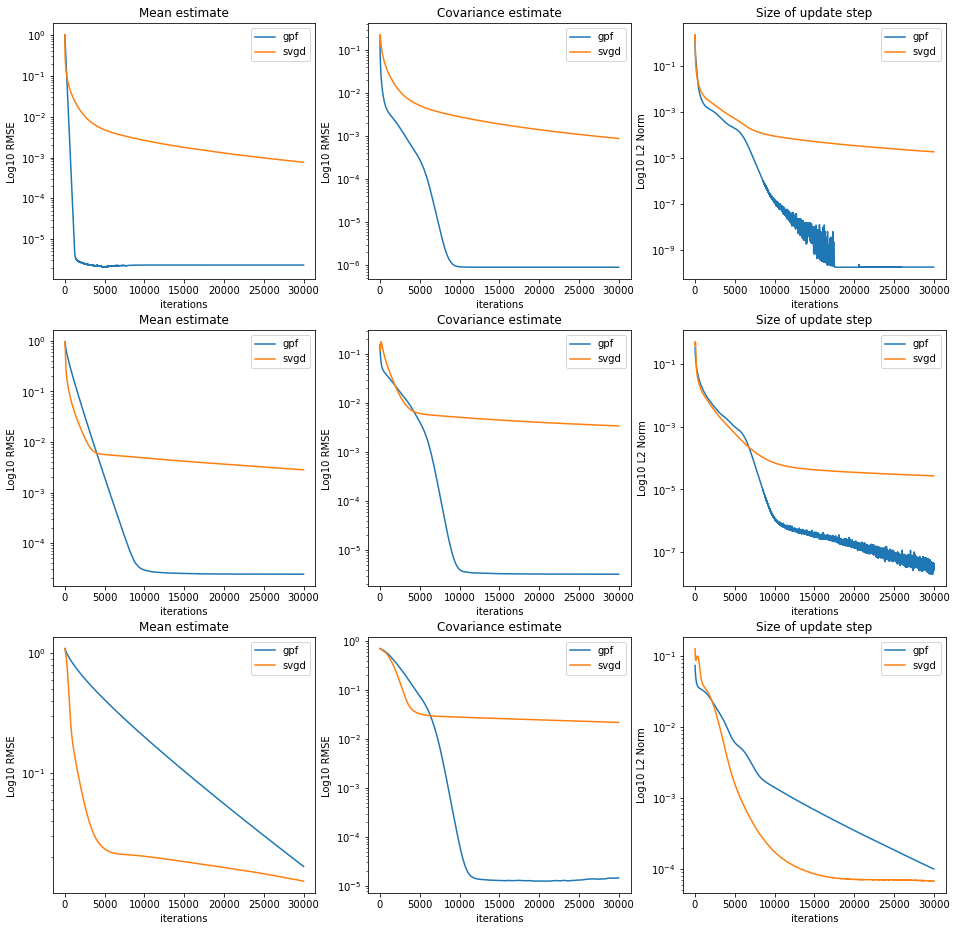

In [182]:
fig,axs = plt.subplots(3,3,figsize=(16,16))
for i in range(3):
    axs[i,0].semilogy(mean_rmse[i].T)
    axs[i,0].set_title('Mean estimate')
    axs[i,0].set_xlabel('iterations')
    axs[i,0].set_ylabel('Log10 RMSE ')
    axs[i,0].legend(['gpf','svgd'])
    axs[i,1].semilogy(cov_rmse[i].T)
    axs[i,1].set_title('Covariance estimate')
    axs[i,1].set_xlabel('iterations')
    axs[i,1].set_ylabel('Log10 RMSE ')
    axs[i,1].legend(['gpf','svgd'])
    axs[i,2].semilogy(l2step[i].T)
    axs[i,2].set_title('Size of update step')
    axs[i,2].set_xlabel('iterations')
    axs[i,2].set_ylabel('Log10 L2 Norm')
    axs[i,2].legend(['gpf','svgd'])
plt.show()

In [185]:
x_gpf.shape

torch.Size([30000, 2, 50])

In [189]:
cov_tr = torch.zeros((len(Cs),len(Ns),2))
for run in np.arange(num_runs):
    for i,C in enumerate(Cs):
        for j,N in enumerate(Ns):
            run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))
            p = torch.load(os.path.join(run_path,'target'))
            x0 = torch.load(os.path.join(run_path,'x0'))
            x_gpf = torch.load(os.path.join(run_path,'x_gpf'))
            x_svgd = torch.load(os.path.join(run_path,'x_svgd'))
            
            cov_tr[i,j,0] += torch.abs(torch.trace(my.estimate_cov(x_gpf[-1]) - p.covariance_matrix))
            cov_tr[i,j,1] += torch.abs(torch.trace(my.estimate_cov(x_svgd[-1]) - p.covariance_matrix))
            #cov_tr[i,j,0] += torch.stack([torch.abs(
            #    torch.trace(my.estimate_cov(x) - p.covariance_matrix)) for x in x_gpf])
            #cov_tr[i,j,1] += torch.stack([torch.abs(
            #    torch.trace(my.estimate_cov(x) - p.covariance_matrix)) for x in x_svgd])
            
cov_tr /= num_runs

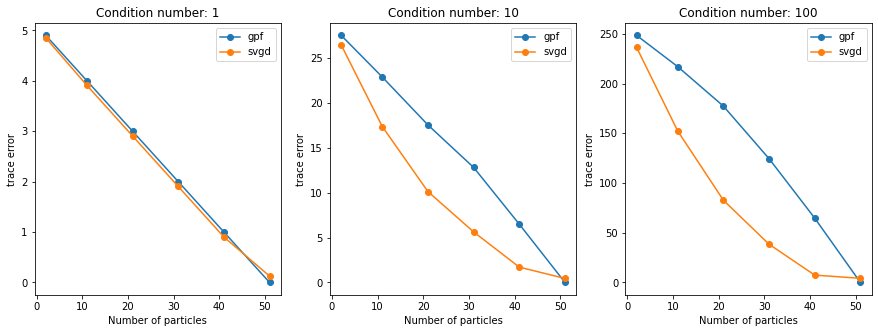

In [190]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].plot(Ns,cov_tr[i,:,0],'o-',label='gpf')
    axs[i].plot(Ns,cov_tr[i,:,1],'o-',label='svgd')
    axs[i].set_ylabel('trace error')
    axs[i].set_xlabel('Number of particles')
    axs[i].set_title('Condition number: {}'.format(Cs[i]))
    axs[i].legend()
plt.show()

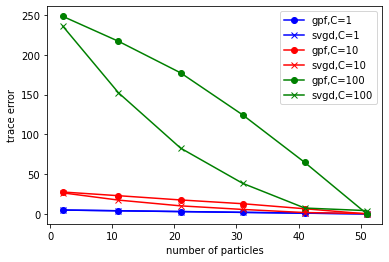

In [192]:
c = ['blue','red','green']
for i in range(3):
    plt.plot(Ns,cov_tr[i,:,0,],'o-',label='gpf,C={}'.format(Cs[i]),color=c[i])
    plt.plot(Ns,cov_tr[i,:,1],'x-',label='svgd,C={}'.format(Cs[i]),color=c[i])
plt.xlabel('number of particles')
plt.ylabel('trace error')

plt.legend()
plt.show()